**Predicting phenotypic states from single cell analysis**

excerpt: Using logistic regression to classify the activation state of a neuron from gene expression using Python and sci-kit learn.
header:
  image: /assets/cellstate/nerve-cell-2213009_1280.jpg
  teaser: /assets/cellstate/nerve-cell-2213009_1280.jpg

[Single-cell analysis](https://en.wikipedia.org/wiki/Single-cell_analysis) has revolutionized biological studies by providing greater resolution to tissue profiling and allowing for rare cell characterization. By far, the most popular application of single-cell analysis is transcriptional profiling of cells; that is, determining what cellular [mRNA](https://en.wikipedia.org/wiki/Messenger_RNA) is being expressed. I've been fortunate to have the opportunity to contribute to this field from my [academic](https://www.nature.com/articles/ncomms11022) and [industry](https://www.fluidigm.com/applications/single-cell-analysis) work.

For some single-cell approaches, it is possible to link phenotypic information about the cell with the thousands of genes that a cell can express. For example, a certain phenotype could be indicated by expression of a known marker [protein](https://en.wikipedia.org/wiki/Protein). The protein's expression can be assessed by [flow sorting](https://en.wikipedia.org/wiki/Flow_cytometry) or cellular imaging with [fluorescence microscopy](https://en.wikipedia.org/wiki/Fluorescence_microscope) upstream of processing for single-cell transcriptome expression. However, it can be labor-intensive or not always possible to phenotype the cell, especially as current experiments scale to [thousands](https://www.nature.com/articles/ncomms14049) of single-cell samples. 

In this project, I am interested in exploring the possibility of using machine learning to train an algorithm towards identifying cellular phenotype based on gene expression alone. I'll use one set of data that we analyzed in my [academic work](https://www.nature.com/articles/ncomms11022). In our study, we looked in the mouse brain and characterized neurons activated by a novel experience. A commonly used phenotype of an activated neuron is whether it expresses the gene Fos (otherwise known as [c-Fos](https://en.wikipedia.org/wiki/C-Fos)).

This dataset begins with 96 samples of which 48 were Fos+ and 48 were Fos-, but as you'll see, filtering steps were applied to reduce the number of samples. The number of genes starts off with over 24,000 but as you see, this also gets reduced with filtering. I then use the unsupervised algorithm of PCA to see how whether activated and non-activated subpopulations separate  following dimensional reduction. Finally, I use logistic regression to train a subset of neurons for classification based on Fos state, then assess the accuracy of the model on a cross-validation subset.

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import data

In [2]:
# Import gene expression data frame
parent_path = '/Users/lacar/Documents/Gage lab/Gage Lab Dropbox/CellIsolation_MethodsPaper/PaperAndFigs/FromOneDrive_finalDocuments/Lab/AnalysisOfSequencing'
child_path = '/SaraRSEM_output/update15_0225/'
os.chdir(parent_path + child_path)
df_tpm = pd.read_table('RSEM_geneSymbol_tpm_141204_allsamples.txt', sep=' ').transpose()

In [4]:
# The genes are the columns (features) of the dataframe,
# while each single-cell sample are the row indexes.
# The values are the expression level of that gene for that sample.
df_tpm.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,22.39,0.0,0.0,0.00,0.0,0.00,0.0,22.03,0.00
nc_ui_ti_C11_141204,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,69.07,0.00
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.0,0.0,173.27,0.0,0.0,...,0.0,2905.22,0.0,0.0,0.00,0.0,0.00,0.0,0.00,5.87
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.0,0.0,0.00,2.3,0.0,...,0.0,156.51,0.0,0.0,2.91,0.0,200.94,0.0,62.27,0.00
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.99,0.00


## Data filtering

### Apply a gene filter

In [13]:
# Filter the dataframe by removing genes that are not expressed in any cell
genes_retained_mask = df_tpm.sum(axis=0)>0
df_tpm_genes_retained = df_tpm.copy()[genes_retained_mask.index[genes_retained_mask]]
df_tpm_genes_retained.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,22.39,0.0,0.0,0.00,0.00,0.0,22.03,0.00
nc_ui_ti_C11_141204,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,69.07,0.00
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.0,0.0,173.27,0.0,0.0,...,0.0,0.0,2905.22,0.0,0.0,0.00,0.00,0.0,0.00,5.87
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.0,0.0,0.00,2.3,0.0,...,0.0,0.0,156.51,0.0,0.0,2.91,200.94,0.0,62.27,0.00
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,2.99,0.00


### Apply a sample filter
Start by exploring the distribution of gene counts for each sample

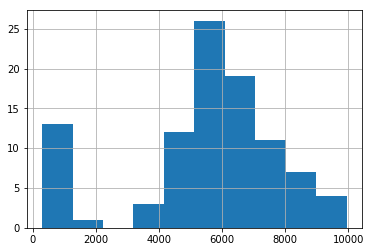

In [14]:
# Filter the dataframe by removing samples with low gene count
df_tpm_genes_retained[df_tpm_genes_retained > 1].count(axis=1).hist();

Removing samples that have less than 3000 genes seems like a logical cutoff.

In [7]:
# Filter the dataframe by removing samples with low gene count (3000 genes)
samples_retained_mask = df_tpm_genes_retained[df_tpm_genes_retained > 1].count(axis=1) > 3000

In [34]:
df_tpm_genes_and_samples_retained = df_tpm_genes_retained.copy()[samples_retained_mask]

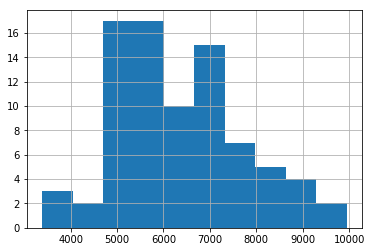

In [35]:
# Sanity check that appropriate filter is implemented
df_tpm_genes_and_samples_retained[df_tpm_genes_and_samples_retained > 1].count(axis=1).hist();

In [36]:
# Create a vector containing the fos label
df_tpm_genes_and_samples_retained.loc[:,'SampleName'] = df_tpm_genes_and_samples_retained.index.copy().tolist()  # temporarily create a sample name vector
df_tpm_genes_and_samples_retained.loc[:,'fos_label'] = df_tpm_genes_and_samples_retained['SampleName'].copy().str.split('_', expand=True)[2]
df_tpm_genes_and_samples_retained.drop('SampleName', axis=1, inplace=True)

In [37]:
df_tpm_genes_and_samples_retained.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,22.39,0.0,0.0,0.00,0.00,0.00,22.03,0.00,ti
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.00,2905.22,0.0,0.0,0.00,0.00,0.00,0.00,5.87,ti
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.00,156.51,0.0,0.0,2.91,200.94,0.00,62.27,0.00,ti
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,2.99,0.00,ti
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,5.87,1045.78,0.0,0.0,0.00,2.41,421.23,113.95,0.00,ti


In [38]:
# Replace labels with 0 and 1 for classification
df_tpm_genes_and_samples_retained['fos_label'].replace(to_replace='ti', value=1, inplace=True)
df_tpm_genes_and_samples_retained['fos_label'].replace(to_replace='tn', value=0, inplace=True)

In [39]:
# Show the number of examples for each group. Note that 1 = FOS+, 0 = FOS-.
df_tpm_genes_and_samples_retained.groupby('fos_label')['fos_label'].count()

fos_label
0    43
1    39
Name: fos_label, dtype: int64

## PCA visualization

Visualize how the groups would separate without using the label. 

In [40]:
X = df_tpm_genes_and_samples_retained.drop('fos_label', axis=1)

In [41]:
# Log transform so features are not spread across different scales
X = np.log2(X+1)

In [42]:
# Run PCA, ignoring the label
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

In [44]:
# Add PCA vectors to dataframe
df_tpm_genes_and_samples_retained.loc[:,'PCAx'] = X[:,0]
df_tpm_genes_and_samples_retained.loc[:,'PCAy'] = X[:,1]

In [45]:
df_tpm_genes_and_samples_retained.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label,PCAx,PCAy
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,22.03,0.00,1,-94.503751,37.229334
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,5.87,1,-85.756057,59.933781
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.0,0.0,2.91,200.94,0.00,62.27,0.00,1,-69.600796,55.139670
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,2.99,0.00,1,-85.647526,45.186168
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,2.41,421.23,113.95,0.00,1,-73.712979,35.147319


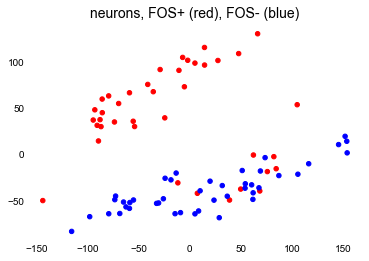

In [46]:
# PCA, colored by FOS state
f, ax1 = plt.subplots(1,1)
cmap = 'bwr'

points = ax1.scatter(df_tpm_genes_and_samples_retained['PCAx'],
                     df_tpm_genes_and_samples_retained['PCAy'],
                     c=df_tpm_genes_and_samples_retained['fos_label'],
                     s=20, cmap=cmap)

# Plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('')
ax1.set_title('neurons, FOS+ (red), FOS- (blue)', size=14)
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)

With the exception of a few FOS+ neurons, the groups separate quite nicely as we showed in the paper. The FOS+ neurons that are amongst the FOS- neurons are discussed further in our paper (we call them pseudo-FOS+ neurons), but for the purposes of this project, I will remove them from further analysis.

In [47]:
# Filtered dataframe by removing pseudo-FOS+ neurons.
mask = (df_tpm_genes_and_samples_retained['fos_label']==1) & (df_tpm_genes_and_samples_retained['PCAy'] < 0)
df_tpm_genes_and_samples_retained_filtered = df_tpm_genes_and_samples_retained.copy()[~mask]   # use ~ to get the inverse of what the mask is getting

In [48]:
# Group sizes moving forward
df_tpm_genes_and_samples_retained_filtered.groupby('fos_label')['fos_label'].count()

fos_label
0    43
1    29
Name: fos_label, dtype: int64

In [49]:
df_tpm_genes_and_samples_retained_filtered.shape

(72, 24348)

In [50]:
# For the purposes of a blog entry, I'm storing this matrix and label.
# X = np.log2(df_tpm_genes_and_samples_retained_filtered.loc[:,:'Zzz3']+1)   # a matrix
# %store X
# y = df_tpm5['fos_label']  # a vector
# %store y

## Supervised machine learning

What machine learning algorithm should I apply? This is a classification problem (FOS+ vs. FOS-) but this is also a situation where the number of *m* examples (72) is much, much smaller than the number of *n* features?  << n features (24345)?

I reviewed my notes from the [Machine Learning course](https://www.coursera.org/learn/machine-learning) I completed and saw that logistic regression or support vector machines without a kernel ("linear") would be good options. Andrew Ng talks about this [here](https://youtu.be/FCUBwP-JTsA?t=867).

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [53]:
df_tpm_genes_and_samples_retained_filtered.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,fos_label,PCAx,PCAy
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,22.03,0.00,1,-94.503751,37.229334
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.00,0.0,173.27,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,5.87,1,-85.756057,59.933781
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.00,0.0,0.00,2.3,0.0,...,0.0,0.0,2.91,200.94,0.00,62.27,0.00,1,-69.600796,55.139670
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,2.99,0.00,1,-85.647526,45.186168
nc_ui_ti_C9_141204,10.13,5.22,0.0,0.0,0.0,2.26,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,2.41,421.23,113.95,0.00,1,-73.712979,35.147319


In [57]:
X = np.log2(df_tpm_genes_and_samples_retained_filtered.drop(['fos_label', 'PCAx', 'PCAy'], axis=1)+1) 
y = df_tpm_genes_and_samples_retained_filtered['fos_label']

### Using all samples for training and testing

This is a first pass at trying the data on this model.

In [60]:
# Instantiate a logistic regression model, and fit with X and y 
model = LogisticRegression()
model = model.fit(X, y)

# Check the accuracy on the training set
model.score(X, y)

1.0

A perfect accuracy, which is awesome, but not entirely surprising for two reasons. We used all of the samples for both training and testing and we saw that PCA split these two groups pretty cleanly. Nevertheless, let's see how the model coefficients look.

In [61]:
# Examining the model coefficients
df_gene_model_coef = pd.DataFrame()
df_gene_model_coef['gene'] = X.columns
df_gene_model_coef['coef'] = np.transpose(model.coef_)
df_gene_model_coef.sort_values(by='coef', ascending=False).head(10)

,gene,coef
2020,Arc,0.013181
17392,Plk2,0.011868
21542,Spry2,0.011055
16864,Pcdh8,0.010792
5467,Etv3,0.010740
1875,Ankrd33b,0.010670
121,1700016P03Rik,0.010454
13538,Ifrd1,0.009955
14424,Lingo1,0.009717
13724,Inhba,0.009200


While the coefficients are not very high, the top gene is Arc, a immediate early gene known for being involved in activity. This is encouraging for our model since it matches what we predict and also what we've shown through differential expression, which is shown in the paper.

### Evaluation by splitting into training and validation sets

In [62]:
# Split into train and test sets. I'll use a ratio of 60/40 of train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Sanity check by evaluating train and test samples and shape

In [63]:
X_train.head(10)

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,...,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
nm_ui_ti_H7_141204,3.450221,3.481557,0.0,0.000000,0.000000,1.189034,0.000000,0.000000,4.395063,0.000000,...,0.000000,0.000000,9.837581,0.0,0.0,0.000000,3.155425,0.000000,1.744161,6.886672
nm_ui_tn_H4_141204,0.000000,4.636335,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.773996,1.914565,0.0,0.0,0.000000,0.000000,0.000000,3.913608,0.000000
nm_ux_ti_E12_141204,2.266037,4.967630,0.0,0.000000,0.000000,0.000000,4.390255,7.780638,0.000000,0.000000,...,5.319401,1.432959,8.924456,0.0,0.0,0.000000,0.632268,1.636915,1.189034,6.513807
nm_ux_ti_F11_141204,2.176323,9.619395,0.0,4.337711,0.000000,0.000000,0.000000,0.000000,1.007196,0.000000,...,0.000000,0.000000,10.233751,0.0,0.0,0.000000,3.850999,0.000000,0.903038,0.000000
nc_ux_tn_B3_141204,0.000000,5.826803,0.0,0.000000,5.202418,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.843984
nc_ui_tn_C6_141204,0.000000,5.305606,0.0,0.000000,0.000000,3.711495,0.000000,0.000000,0.000000,0.000000,...,0.000000,11.446024,3.165108,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
nm_ux_tn_F4_141204,3.253989,3.914565,0.0,0.000000,0.000000,4.081510,6.567119,0.000000,0.000000,8.909863,...,5.901591,0.713696,4.434295,0.0,0.0,0.000000,1.144046,5.787119,5.939227,5.942515
nc_ui_tn_D6_141204,0.000000,6.260778,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,9.599504,0.0,0.0,0.000000,0.000000,0.000000,4.535431,0.000000
nc_ux_tn_A6_141204,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,9.227905,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.257199,0.000000,0.000000,0.000000,6.616475
nm_ux_ti_E10_141204,3.647315,2.025029,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,10.468573,0.0,0.0,1.459432,8.696620,0.000000,6.900746,0.000000


In [64]:
print('training set shape: ', X_train.shape, 'test set shape: ', X_test.shape)

training set shape:  (43, 24345) test set shape:  (29, 24345)


#### Run predictions!

In [65]:
# Predict fos labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0]


In [66]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[9.98426233e-01, 1.57376682e-03],
       [9.96202992e-01, 3.79700766e-03],
       [9.73881063e-01, 2.61189367e-02],
       [1.34778429e-03, 9.98652216e-01],
       [9.98174673e-01, 1.82532739e-03],
       [9.56475048e-01, 4.35249519e-02],
       [9.35189395e-01, 6.48106052e-02],
       [3.64984026e-03, 9.96350160e-01],
       [9.98424400e-01, 1.57559995e-03],
       [9.99574009e-01, 4.25991497e-04],
       [5.94209783e-03, 9.94057902e-01],
       [9.99011203e-01, 9.88796758e-04],
       [9.99384087e-01, 6.15912531e-04],
       [9.93084404e-01, 6.91559568e-03],
       [9.99386019e-01, 6.13981338e-04],
       [8.64687787e-04, 9.99135312e-01],
       [9.98006666e-01, 1.99333438e-03],
       [9.98435314e-01, 1.56468584e-03],
       [9.65425063e-01, 3.45749367e-02],
       [1.63809596e-02, 9.83619040e-01],
       [9.93428494e-01, 6.57150644e-03],
       [9.38801303e-01, 6.11986970e-02],
       [4.03005103e-03, 9.95969949e-01],
       [4.68981046e-03, 9.95310190e-01],
       [9.865083

In [72]:
# generate evaluation metrics
print('Accuracy score: ', metrics.accuracy_score(y_test, predicted))
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy score:  0.9655172413793104
ROC AUC:  1.0


In [73]:
print('Confusion matrix: \n',
      'TP', 'FN\n', 'FP', 'TN\n',
      metrics.confusion_matrix(y_test, predicted, labels=[1, 0]))

Confusion matrix: 
 TP FN
 FP TN
 [[ 9  1]
 [ 0 19]]


In [70]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97        19
          1       1.00      0.90      0.95        10

avg / total       0.97      0.97      0.97        29



Therefore, all 18 FOS- neurons were predicted correctly while 11 of the 12 FOS+ neurons were predicted correctly. You can see the actual sample that was missed in the table below.

In [71]:
pd.DataFrame({'actual': y_test, 'predicted': predicted})

,actual,predicted
nc_ux_tn_A3_141204,0,0
nc_ux_tn_A4_141204,0,0
nm_ui_tn_H3_141204,0,0
nc_ux_ti_A8_141204,1,1
nc_ux_tn_B1_141204,0,0
nm_ui_tn_H6_141204,0,0
nc_ui_ti_D7_141204,1,0
nm_ux_ti_F8_141204,1,1
nc_ux_tn_B5_141204,0,0
nm_ux_tn_F6_141204,0,0


## Summary

The goal of this classification project was to determine if we could train an algorithm to predict cellular phenotype based on gene expression. Using a previously published dataset based on activated neurons, I establish proof-of-principle that this is possible. Application of logistic regression leads to an accuracy score of 96.5%, which was just one actual FOS+ neuron falsely called as FOS-. This is pretty good when looking at two different cellular states for this sample size. Possible next steps are to try a different classification algorithm (like SVM) to try and get perfect accuracy, scale up and do more samples, and/or do more cellular phenotypes. Ultimately, this approach has the potential to enhance the value of single-cell applications, by providing phenotypic information in experiments where it would difficult or impossible to experimentally assess.